In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)
os.system(f"export CUDA_VISIBLE_DEVICSE=0")

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import torch
from torch.amp import autocast
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [2]:
model_size_dict = {
    'base': {
        'config': '03_31_13_12//config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/03_31_13_12//checkpoints/checkpoint_400.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
amp_type = torch.bfloat16 if device == 'cuda' else torch.float32
submodel, object_labels, _, loss = build_sam2former(config, ck, device=device)
print(device)

OmegaConf resolved successfully


/home/guests/tuna_gurbuz/prototype/custom_models/models/sam2former/msdeformattn.py:310: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


cpu


In [3]:
for ii in range(6):
    before = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    print("before", before)
    print(torch.all(before == 0))
sd = torch.load(ck, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = submodel.load_state_dict(sd, strict=False)
for ii in range(6):
    after = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    print("after", after)
    print(torch.all(after == 0))

before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
tensor(True)
before Parameter containing:
tensor([[0., 0., 0.,  .

In [4]:
# for key in sd.keys():
#     if "sam_mask_decoder.pixel_decoder.transformer" in key:
#         print(key)
sd['sam_mask_decoder.pixel_decoder.transformer.encoder.layers.0.self_attn.sampling_offsets.weight']

tensor([[ 0.0020, -0.0016, -0.0004,  ..., -0.0028, -0.0029,  0.0024],
        [ 0.0014, -0.0014,  0.0021,  ..., -0.0013,  0.0004, -0.0028],
        [-0.0043,  0.0055, -0.0016,  ..., -0.0028, -0.0018,  0.0029],
        ...,
        [ 0.0014, -0.0044, -0.0024,  ...,  0.0006,  0.0002,  0.0030],
        [-0.0002,  0.0017, -0.0004,  ...,  0.0021, -0.0009, -0.0016],
        [-0.0020, -0.0014,  0.0014,  ...,  0.0003, -0.0036, -0.0041]])

In [5]:
# Dataset
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# revert_mean=[-.485/.229, -.456/.224, -.406/.225]
# revert_std=[1/.229, 1/.224, 1/.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


Lenght of the dataset! 1


In [6]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False

test_loader = test_dataset.get_loader()
with torch.no_grad():
    submodel.train()
    for idx, batch in enumerate(test_loader):
        batched_video_data_val = batch[0].to(device)
        seg_mask = batch[1]  # List of PIL Image for debug
        masks_val = batch[0].masks.to(device)
        with autocast(device_type=device, dtype=amp_type):
            all_frame_outputs_val = submodel(batched_video_data_val)

/home/guests/tuna_gurbuz/miniforge3/envs/trainenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:283: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16, torch.float16 currently.
  warnings.warn(error_message)


/home/guests/tuna_gurbuz/miniforge3/envs/trainenv/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# Image
image = batched_video_data_val.img_batch[0,0].cpu()
unnormalized_image = toPILimage(revert_transform(image))
# GT Mask
gt_mask = masks_val[0,0].cpu()

In [9]:
batch = batch[0]
batch_size = len(batch.img_batch)
key = batch.dict_key  # key for dataset
targets = []

for i in range(batch_size):
    # dim=2 video_id, obj_id, frame_id
    xx, yy = torch.where(batch.metadata.unique_objects_identifier[:,:,2] == i)
    obj_id = batch.metadata.unique_objects_identifier[xx,yy,1]
    targets.append({
        "masks": batch.masks[i],
        "labels": obj_id,
    })
    
loss[key](all_frame_outputs_val, targets)

/home/guests/tuna_gurbuz/prototype/custom_models/models/sam2former/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


{'loss_class': tensor(1.9073e-06),
 'loss_mask': tensor(0.0096),
 'loss_dice': tensor(0.0241),
 'total_loss': tensor(0.1685),
 'core_loss': tensor(0.1685)}

In [10]:
# Predicted Mask
pred_logits = all_frame_outputs_val[0]['pred_logits'][0].cpu()
best_logits = torch.argmax(pred_logits, dim=1)
bin_pred_masks = (all_frame_outputs_val[0]['pred_masks'].sigmoid()).float()
masks = bin_pred_masks[0].cpu()

In [11]:
print("Predicted logits", pred_logits.softmax(dim=-1).max(dim=-1))
mask_logit = all_frame_outputs_val[0]['pred_masks'][0].cpu()
masks = torch.cat([masks, mask_logit], dim=0)

Predicted logits torch.return_types.max(
values=tensor([1.0000]),
indices=tensor([0]))


IndexError: index 2 is out of bounds for dimension 0 with size 2

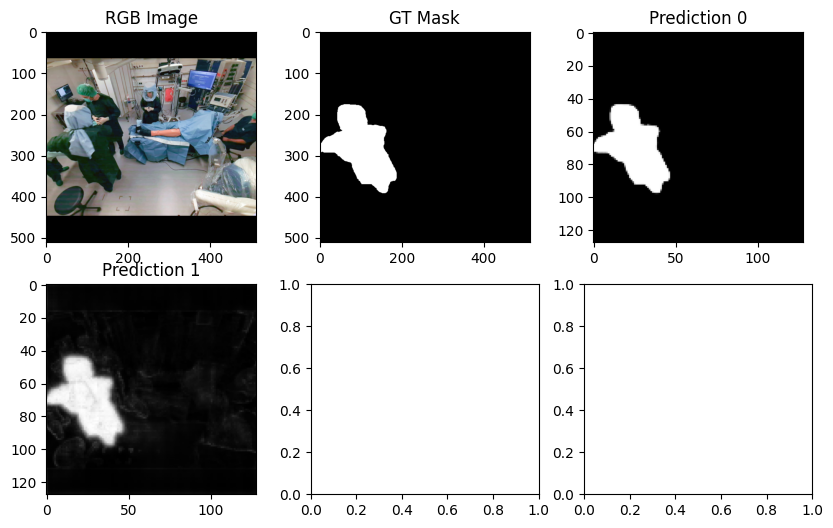

In [ ]:
obj_out_idx = 0
black_placeholder = np.zeros_like(gt_mask)  # Black image placeholder

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(gt_mask, cmap='gray')
axes[0, 1].set_title("GT Mask")

axes[0, 2].imshow(masks[0], cmap='gray')
axes[0, 2].set_title("Prediction 0")

# Second row (Predictions)
axes[1, 0].imshow(masks[1], cmap='gray')
axes[1, 0].set_title("Prediction 1")

axes[1, 1].imshow(masks[2], cmap='gray')
axes[1, 1].set_title("Prediction 2")

axes[1, 2].imshow(masks[3], cmap='gray')
axes[1, 2].set_title("Prediction 3")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()